In [1]:
!date

Wed Nov 18 15:31:28 PST 2020


# Matrix Generation Clean Up

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

def nd(arr):
    return np.array(arr).reshape(-1)

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
adata = "../../data/SMARTseq/out_cr_index/annotated_adata.h5ad"
adata = anndata.read_h5ad(adata)
adata.var["gene_name"] = adata.var["gene_name"].astype(str) + "_" + adata.var.gene_id.astype(str)
adata.var["transcript_name"] = adata.var["transcript_name"].astype(str) + "_" + adata.var.transcript_id.astype(str)

In [3]:
def change(x):
    if x=="L5 ET": return "L5 PT"
    return x

In [4]:
adata.obs.cluster_label = adata.obs.cluster_label.apply(change).values
adata.obs.subclass_label = adata.obs.subclass_label.apply(change).values

In [5]:
adata.obs.subclass_label.value_counts()

L5 IT          1571
L6 CT           904
Vip             659
L6b             571
Pvalb           543
L2/3 IT         483
Sst             427
L6 IT           395
Lamp5           377
L5/6 NP         208
Sncg             84
SMC              21
L5 PT            12
Low Quality      12
Astro            10
Endo              7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

In [6]:
lengths = pd.read_csv("../../reference/length_info.txt", header=None, names=["length", "transcript_id", "gene_id", "gene_name", "transcript_name", "chr", "start", "end", "strand"], sep="\t")
lengths["transcript_id"] = lengths["transcript_id"].apply(lambda x: x.split(".")[0])
lengths.index = lengths.transcript_id.values

In [7]:
adata.var["length"] = adata.var.transcript_id.map(lengths["length"])

In [8]:
adata.var.head()

,transcript_id,gene_id,gene_name,transcript_name,length
0,ENSMUST00000162897,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-203_ENSMUST00000162897,4153
1,ENSMUST00000159265,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-202_ENSMUST00000159265,2989
2,ENSMUST00000070533,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-201_ENSMUST00000070533,3634
3,ENSMUST00000161581,ENSMUSG00000089699,Gm1992_ENSMUSG00000089699,Gm1992-201_ENSMUST00000161581,250
4,ENSMUST00000194643,ENSMUSG00000102343,Gm37381_ENSMUSG00000102343,Gm37381-202_ENSMUST00000194643,657


In [9]:
raw = adata.X.todense()

In [10]:
x = nd(raw.sum(axis=1))

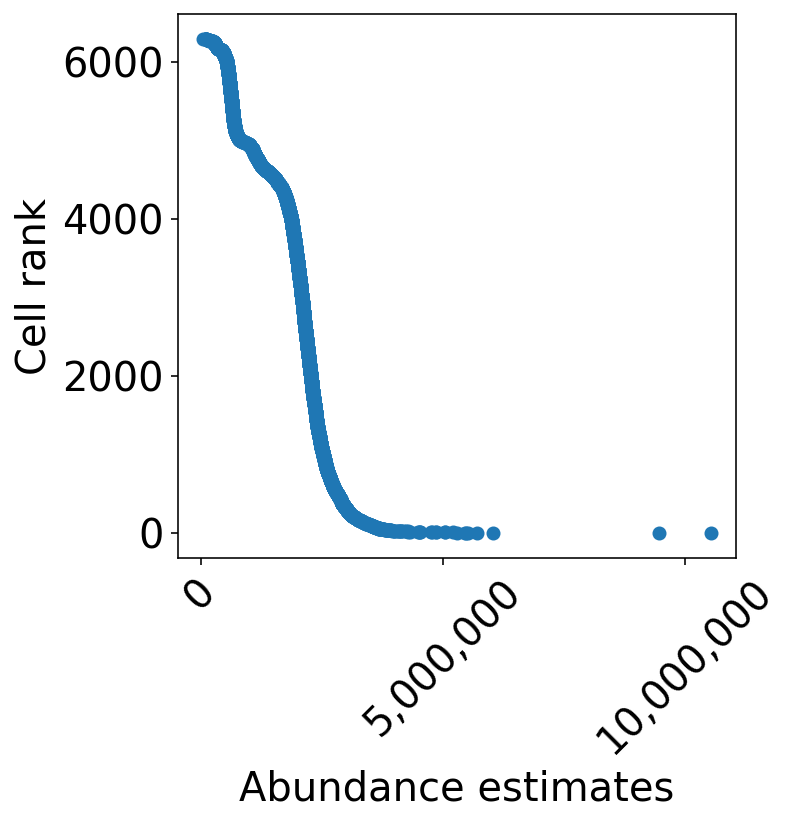

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(np.sort(x)[::-1], np.arange(x.shape[0]))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax.set(**{
    "xlabel": "Abundance estimates",
    "ylabel": "Cell rank",
})

fig.show()

# Basic matrix transforms

In [12]:
scaled = raw/adata.var.length.values

In [13]:
adata.layers["raw"] = csr_matrix(raw)
adata.layers["scaled"] = csr_matrix(scaled)

adata.layers["norm"] = normalize(scaled, norm='l1', axis=1)*1000000

In [14]:
adata.layers["norm"][0].sum()

999999.9999999998

In [15]:
adata.layers["log1p"] = np.log1p(adata.layers["norm"])

In [16]:
del raw
del scaled

In [17]:
def group_mtx(mtx, components, features, s2t, source_id="transcript_id", target_id="gene_id", by="features"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((ncomp, nuniq))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        
        # breaks generality
        sub_mtx = mtx[:, source_indices].sum(axis=1) # Sum on source indicies
        X[:,tidx] = np.asarray(sub_mtx)[:,0] # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)
    
def filter_mtx(mtx, components, features, **kwargs):
    row_counts = kwargs.get("row_counts", 0) # threshold for min counts for rows
    col_counts = kwargs.get("col_counts", 0)
    row_zeros  = kwargs.get("row_zeros", 0) # threshold min number of non_zero entries in rows
    col_zeros  = kwargs.get("col_zeros", 0)
    
    return_mask = kwargs.get("return_mask", False)
    
    row_sum = np.asarray(mtx.sum(axis=1)).reshape(-1) # sum along the rows
    col_sum = np.asarray(mtx.sum(axis=0)).reshape(-1)
    
    mtx_zero_mask = mtx>0
    row_nz = np.asarray(mtx_zero_mask.sum(axis=1)).reshape(-1)
    col_nz = np.asarray(mtx_zero_mask.sum(axis=0)).reshape(-1)
    
    # Generate masks
    rs_mask = row_sum > row_counts
    cs_mask = col_sum > col_counts
    
    rz_mask = row_nz > row_zeros
    cz_mask = col_nz > col_zeros
    
    row_mask = np.logical_and(rs_mask, rz_mask)
    col_mask = np.logical_and(cs_mask, cz_mask)
    
    if return_mask:
        return (row_mask, col_mask)
    
    X = mtx[row_mask,:][:,col_mask]
    c = components[row_mask]
    f = features[col_mask]
    
    return (X, c, f)

### test the filter step

In [18]:
%%time

mtx = np.array([[1,1,0],
                [0,1,0],
                [3,0,0],
                [0,2,0]])

components = np.array([1,2,3,4])
features = np.array([1, 2, 3])

X, c, f = filter_mtx(mtx, components, features, row_zeros=1, col_zeros=3)
rm, cmask = filter_mtx(mtx, components, features, return_mask=True)

CPU times: user 257 µs, sys: 73 µs, total: 330 µs
Wall time: 297 µs


In [19]:
print(cmask)
print(X)
print(X==mtx)

[ True  True False]
[]
False


# Group isoforms into genes, and filter. 

go back and filter on isoforms and apply it to genes

In [20]:
%%time

mtx        = adata.layers["scaled"] # sum scaled abundances
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values


rm, cmask = filter_mtx(mtx, components, features, col_counts=1, col_zeros=1, return_mask=True)

CPU times: user 1.38 s, sys: 600 ms, total: 1.98 s
Wall time: 1.98 s


In [21]:
cmask.sum()

69360

# Save the raw isoform and gene matrix

In [23]:
adata

AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'raw', 'scaled', 'norm', 'log1p'

In [24]:
%%time

mtx        = adata.layers["scaled"].todense()
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values

source_id = "transcript_id"
target_id = "gene_id"


s2t = adata.var

# Data for gene matrix
X, c, f = group_mtx(mtx, components, features, s2t)

CPU times: user 25.1 s, sys: 7.09 s, total: 32.2 s
Wall time: 32.2 s


In [25]:
# generate gene
tmp = adata.var.drop_duplicates(["gene_id", "gene_name"])
tmp = tmp[tmp.gene_id.isin(f)]
gene = anndata.AnnData(X=X, obs=adata.obs, var=tmp)

In [26]:
print(adata)
print(gene)

AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'raw', 'scaled', 'norm', 'log1p'
AnnData object with n_obs × n_vars = 6295 × 31053
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'


In [28]:
adata.write_h5ad("../../data/notebook/revision/no_filter_smartseq_isoform.h5ad")
gene.write_h5ad("../../data/notebook/revision/no_filter_smartseq_gene.h5ad")

... storing 'gene_name' as categorical


# Filter isoform and gene matrix 

In [29]:
filtered_adata = adata[:,cmask]

In [30]:
print(filtered_adata)
print(adata)

View of AnnData object with n_obs × n_vars = 6295 × 69360
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'raw', 'scaled', 'norm', 'log1p'
AnnData object with n_obs × n_vars = 6295 × 111079
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'raw', 'scaled', 'norm', 'log1p'


In [31]:
%%time

mtx        = filtered_adata.layers["scaled"].todense()
components = filtered_adata.obs.cell_id.values
features   = filtered_adata.var.transcript_id.values

source_id = "transcript_id"
target_id = "gene_id"


s2t = filtered_adata.var

# Data for gene matrix
X, c, f = group_mtx(mtx, components, features, s2t)

CPU times: user 15.9 s, sys: 2.96 s, total: 18.8 s
Wall time: 18.8 s


In [32]:
# generate isoform based on gene mask.
isoform = filtered_adata[:, filtered_adata.var.gene_id.isin(f)]

In [33]:
isoform

View of AnnData object with n_obs × n_vars = 6295 × 69360
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'raw', 'scaled', 'norm', 'log1p'

In [34]:
# generate gene
tmp = filtered_adata.var.drop_duplicates(["gene_id", "gene_name"])
tmp = tmp[tmp.gene_id.isin(f)]
gene = anndata.AnnData(X=X, obs=filtered_adata.obs, var=tmp)

In [35]:
print(isoform)
print(gene)

View of AnnData object with n_obs × n_vars = 6295 × 69360
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'raw', 'scaled', 'norm', 'log1p'
AnnData object with n_obs × n_vars = 6295 × 19375
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'


In [36]:
gene.var.index = gene.var.gene_name.values
isoform.var.index = isoform.var.transcript_name.values

In [37]:
x = nd(isoform.layers["scaled"].sum(axis=1))

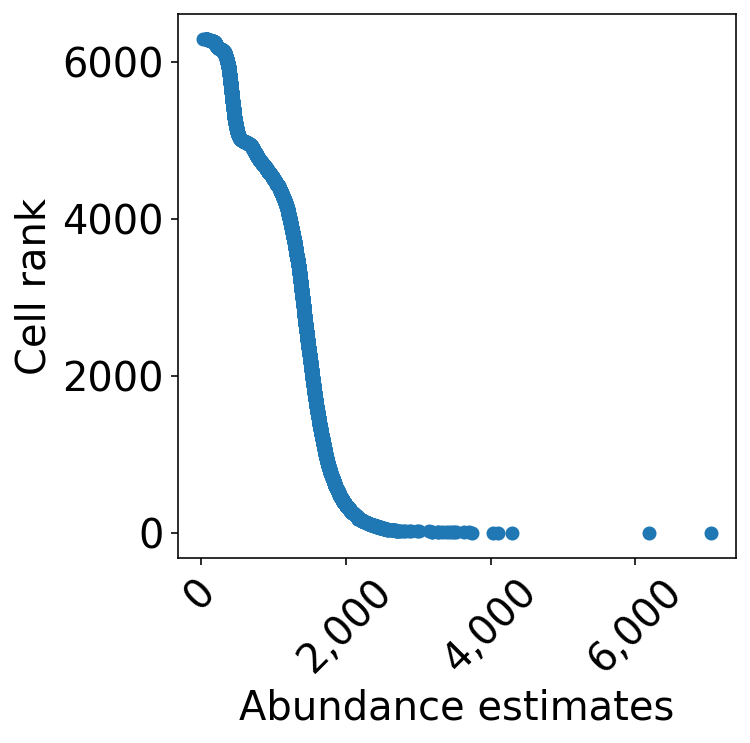

In [38]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(np.sort(x)[::-1], np.arange(x.shape[0]))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax.set(**{
    "xlabel": "Abundance estimates",
    "ylabel": "Cell rank",
})

fig.show()

# Begin Check

In [39]:
# the gene_id is OK, need to fix the gene name to reflected the fact that
# the same gene_name is used with multiple gene_ids

In [40]:
filtered_adata.var.gene_id.nunique() == gene.var.gene_name.nunique()

True

In [41]:
filtered_adata.var.transcript_id.nunique() == isoform.var.transcript_name.nunique()

True

In [42]:
gene.X = csr_matrix(gene.X)

In [43]:
gene.layers["scaled"] = gene.X.copy() # here, X is rho, the number of molecules

# Perform matrix operations

In [44]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

### Adding info to rows/cols

In [45]:
# turning subclass_label into an id
le = LabelEncoder()
gene.obs["subclass_id"] = le.fit_transform(gene.obs.subclass_label.values)
isoform.obs["subclass_id"] = le.fit_transform(isoform.obs.subclass_label.values)

Trying to set attribute `.obs` of view, copying.


In [46]:
# turning class_label into an id
le = LabelEncoder()
gene.obs["class_id"] = le.fit_transform(gene.obs.class_label.values)
isoform.obs["class_id"] = le.fit_transform(isoform.obs.class_label.values)

In [47]:
gene.var["gene_id"] = gene.var["gene_id"].astype(str)

In [48]:
# Adding list and number of isoforms to each gene
g2t = isoform.var.groupby("gene_id")["transcript_id"].apply(list)
gene.var["txn_list"] = gene.var["gene_id"].map(g2t)
num_iso = g2t.apply(lambda x: len(x))
gene.var["num_isoforms"] = gene.var["gene_id"].map(num_iso).astype(int)

In [49]:
# Writing cell_TPM, gene_TPM, n_genes, and percent_mito for each cell
gene.obs["cell_counts"] = gene.X.sum(1)
gene.var["gene_counts"] = np.asarray(gene.X.sum(0)).reshape(-1)

isoform.obs["cell_counts"] = isoform.X.sum(1)
isoform.var["gene_counts"] = np.asarray(isoform.X.sum(0)).reshape(-1)

mito_genes = gene.var_names.str.startswith('mt-')
gene.obs["percent_mito"] = gene[:,mito_genes].X.sum(axis=1)/gene.X.sum(axis=1)*100
gene.obs["n_genes"] = (gene.X>0).sum(axis=1)

In [50]:
# For each gene, compute the dispersion and store it
mtx = gene.X.todense()
mean = np.asarray(mtx.mean(axis=0)).reshape(-1)
var = np.asarray(np.power(mtx, 2).mean(axis=0)).reshape(-1) - mean**2

dispersion = var / mean

In [51]:
gene.var["dispersion"] = dispersion
gene.var["pass_disp_filter"] = gene.var["dispersion"] > disp_threshold

In [52]:
gene.var["pass_disp_filter"].sum()

19190

In [53]:
gene.obs["pass_count_filter"] = gene.obs["cell_counts"] > cell_threshold

In [54]:
gene.obs["pass_count_filter"].sum()

6175

### Filtering

In [55]:
gene.shape

(6295, 19375)

In [56]:
isoform.shape

(6295, 69360)

In [57]:
l = gene.var.txn_list[gene.var.pass_disp_filter].values
flat_list = [item for sublist in l for item in sublist]

In [58]:
gene_disp_mask = gene.var["pass_disp_filter"].values
gene_cell_mask = gene.obs["pass_count_filter"].values

iso_disp_mask = isoform.var["transcript_id"].isin(flat_list)
iso_cell_mask = gene.obs["pass_count_filter"].values

In [59]:
print(gene_cell_mask.sum(), gene_disp_mask.sum())
print(iso_cell_mask.sum(), iso_disp_mask.sum())

6175 19190
6175 69172


In [60]:
gene = gene[gene_cell_mask, gene_disp_mask]
isoform = isoform[iso_cell_mask, iso_disp_mask]

In [61]:
print(isoform.shape)
print(gene.shape)

(6175, 69172)
(6175, 19190)


In [62]:
mito_mask = (gene.obs.percent_mito < mito_criteria).values

In [63]:
mito_mask.sum()

6160

In [64]:
gene = gene[mito_mask,:]
isoform = isoform[mito_mask,:]

In [65]:
print(gene.shape)
print(isoform.shape)

(6160, 19190)
(6160, 69172)


In [66]:
6295-6160

135

### Adding info to matrices

In [67]:
gene.layers["norm"] = normalize(gene.layers["scaled"], norm='l1', axis=1)*1000000
isoform.layers["norm"] = normalize(isoform.layers["scaled"], norm='l1', axis=1)*1000000

In [68]:
gene.layers["log1p"] = np.log1p(gene.layers["norm"])
isoform.layers["log1p"] = np.log1p(isoform.layers["norm"])

In [69]:
gene.X = gene.layers["log1p"]
isoform.X = isoform.layers["log1p"]

In [70]:
tmp = gene.copy()

In [71]:
scanp.pp.log1p(tmp)

In [72]:
d = tmp.uns

In [73]:
gene.uns = d
isoform.uns = d

### Highly Variable Genes

In [76]:
scanp.pp.highly_variable_genes(gene, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = gene.var.highly_variable.values

In [77]:
scanp.pp.highly_variable_genes(isoform, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvi_mask = isoform.var.highly_variable.values

### Scaling data to unit variance, zero mean for clustering

In [78]:
from sklearn.preprocessing import scale

In [79]:
%%time
mat = gene.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
gene.X = mtx

CPU times: user 3.44 s, sys: 1.71 s, total: 5.15 s
Wall time: 5.15 s


In [80]:
%%time
mat = isoform.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
isoform.X = mtx

CPU times: user 16.6 s, sys: 7.63 s, total: 24.2 s
Wall time: 24.2 s


## **START CHECKPOINT**

In [80]:
# gene = tmp_gene.copy()
# isoform = tmp_isoform.copy()

In [81]:
gene

AnnData object with n_obs × n_vars = 6160 × 19190
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'scaled', 'norm', 'log1p'

In [82]:
isoform

AnnData object with n_obs × n_vars = 6160 × 69172
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw', 'scaled', 'norm', 'log1p'

In [83]:
x = nd(isoform.layers["scaled"].sum(axis=1))

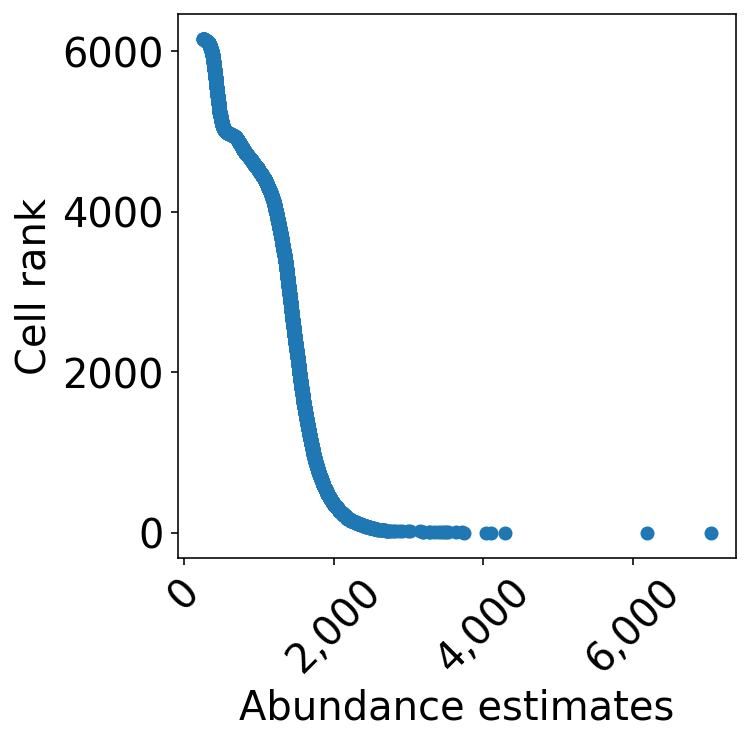

In [84]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(np.sort(x)[::-1], np.arange(x.shape[0]))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax.set(**{
    "xlabel": "Abundance estimates",
    "ylabel": "Cell rank",
})

fig.show()

## **END CHECKPOINT**

### TSVD on highly variable genes

In [86]:
print("TSVD on {:,} variable genes to {} components.".format(n_top_genes, num_PCA))

TSVD on 5,000 variable genes to 50 components.


In [87]:
# PCA
X = gene.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
gene.obsm["X_pca"] = tsvd.fit_transform(X)

X = isoform.X[:,hvi_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
isoform.obsm["X_pca"] = tsvd.fit_transform(X)

### Clustering

In [88]:
scanp.pp.neighbors(gene, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)
scanp.pp.neighbors(isoform, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [89]:
scanp.tl.leiden(gene, random_state=state)
scanp.tl.leiden(isoform, random_state=state)

In [90]:
scanp.tl.louvain(gene, random_state=state)
scanp.tl.louvain(isoform, random_state=state)

## Dimensionality Reduction

In [91]:
# TSNE
X = gene.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
gene.obsm["X_pca_tsne"] = tsne.fit_transform(X)

X = isoform.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
isoform.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [92]:
# NCA
X = gene.X
y = gene.obs.subclass_id.values

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
gene.obsm["X_nca"] = nca.fit_transform(X, y)

In [93]:
# NCA
X = isoform.X
y = isoform.obs.subclass_id.values

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
isoform.obsm["X_nca"] = nca.fit_transform(X, y)

In [94]:
X = gene.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
gene.obsm["X_nca_tsne"] = tsne.fit_transform(X)

In [95]:
X = isoform.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
isoform.obsm["X_nca_tsne"] = tsne.fit_transform(X)

## Saving

In [93]:
isoform.write("../../data/notebook/revision/isoform.h5ad")
gene.write("../../data/notebook/revision/gene.h5ad")

... storing 'gene_name' as categorical


In [94]:
# gene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")

In [96]:
isoform

AnnData object with n_obs × n_vars = 6160 × 69172
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'leiden', 'louvain'
    obsm: 'X_pca', 'X_pca_tsne', 'X_nca', 'X_nca_tsne'
    layers: 'raw', 'scaled', 'norm', 'log1p'
    obsp: 'distances', 'connectivities'

In [97]:
isoform[:, isoform.var["gene_name"].str.contains("Tcea1")].layers["log1p"].todense()[0:10]

matrix([[5.34415625, 1.58616261],
        [5.08426687, 0.        ],
        [4.6708635 , 0.        ],
        [4.35962441, 0.        ],
        [4.08707223, 2.66915542],
        [4.97549061, 0.64806416],
        [5.00219153, 0.        ],
        [5.16390132, 0.        ],
        [4.6351808 , 0.        ],
        [4.23016649, 1.20960528]])

In [132]:
isoform[:, isoform.var["gene_name"].str.contains("Tcea1")].X[0:10]

ArrayView([[ 1.12332304,  0.74251939],
           [ 0.77112929, -0.68293269],
           [ 0.21089831, -0.68293269],
           [-0.21088299, -0.68293269],
           [-0.58023706,  1.71578297],
           [ 0.62371912, -0.10053061],
           [ 0.65990343, -0.68293269],
           [ 0.87904735, -0.68293269],
           [ 0.16254223, -0.68293269],
           [-0.38632026,  0.40411499]])

# Loading back in

In [2]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

# Plotting

### TSNE on PCA components

In [98]:
print("Number of PCs: {}".format(num_PCA))

Number of PCs: 50


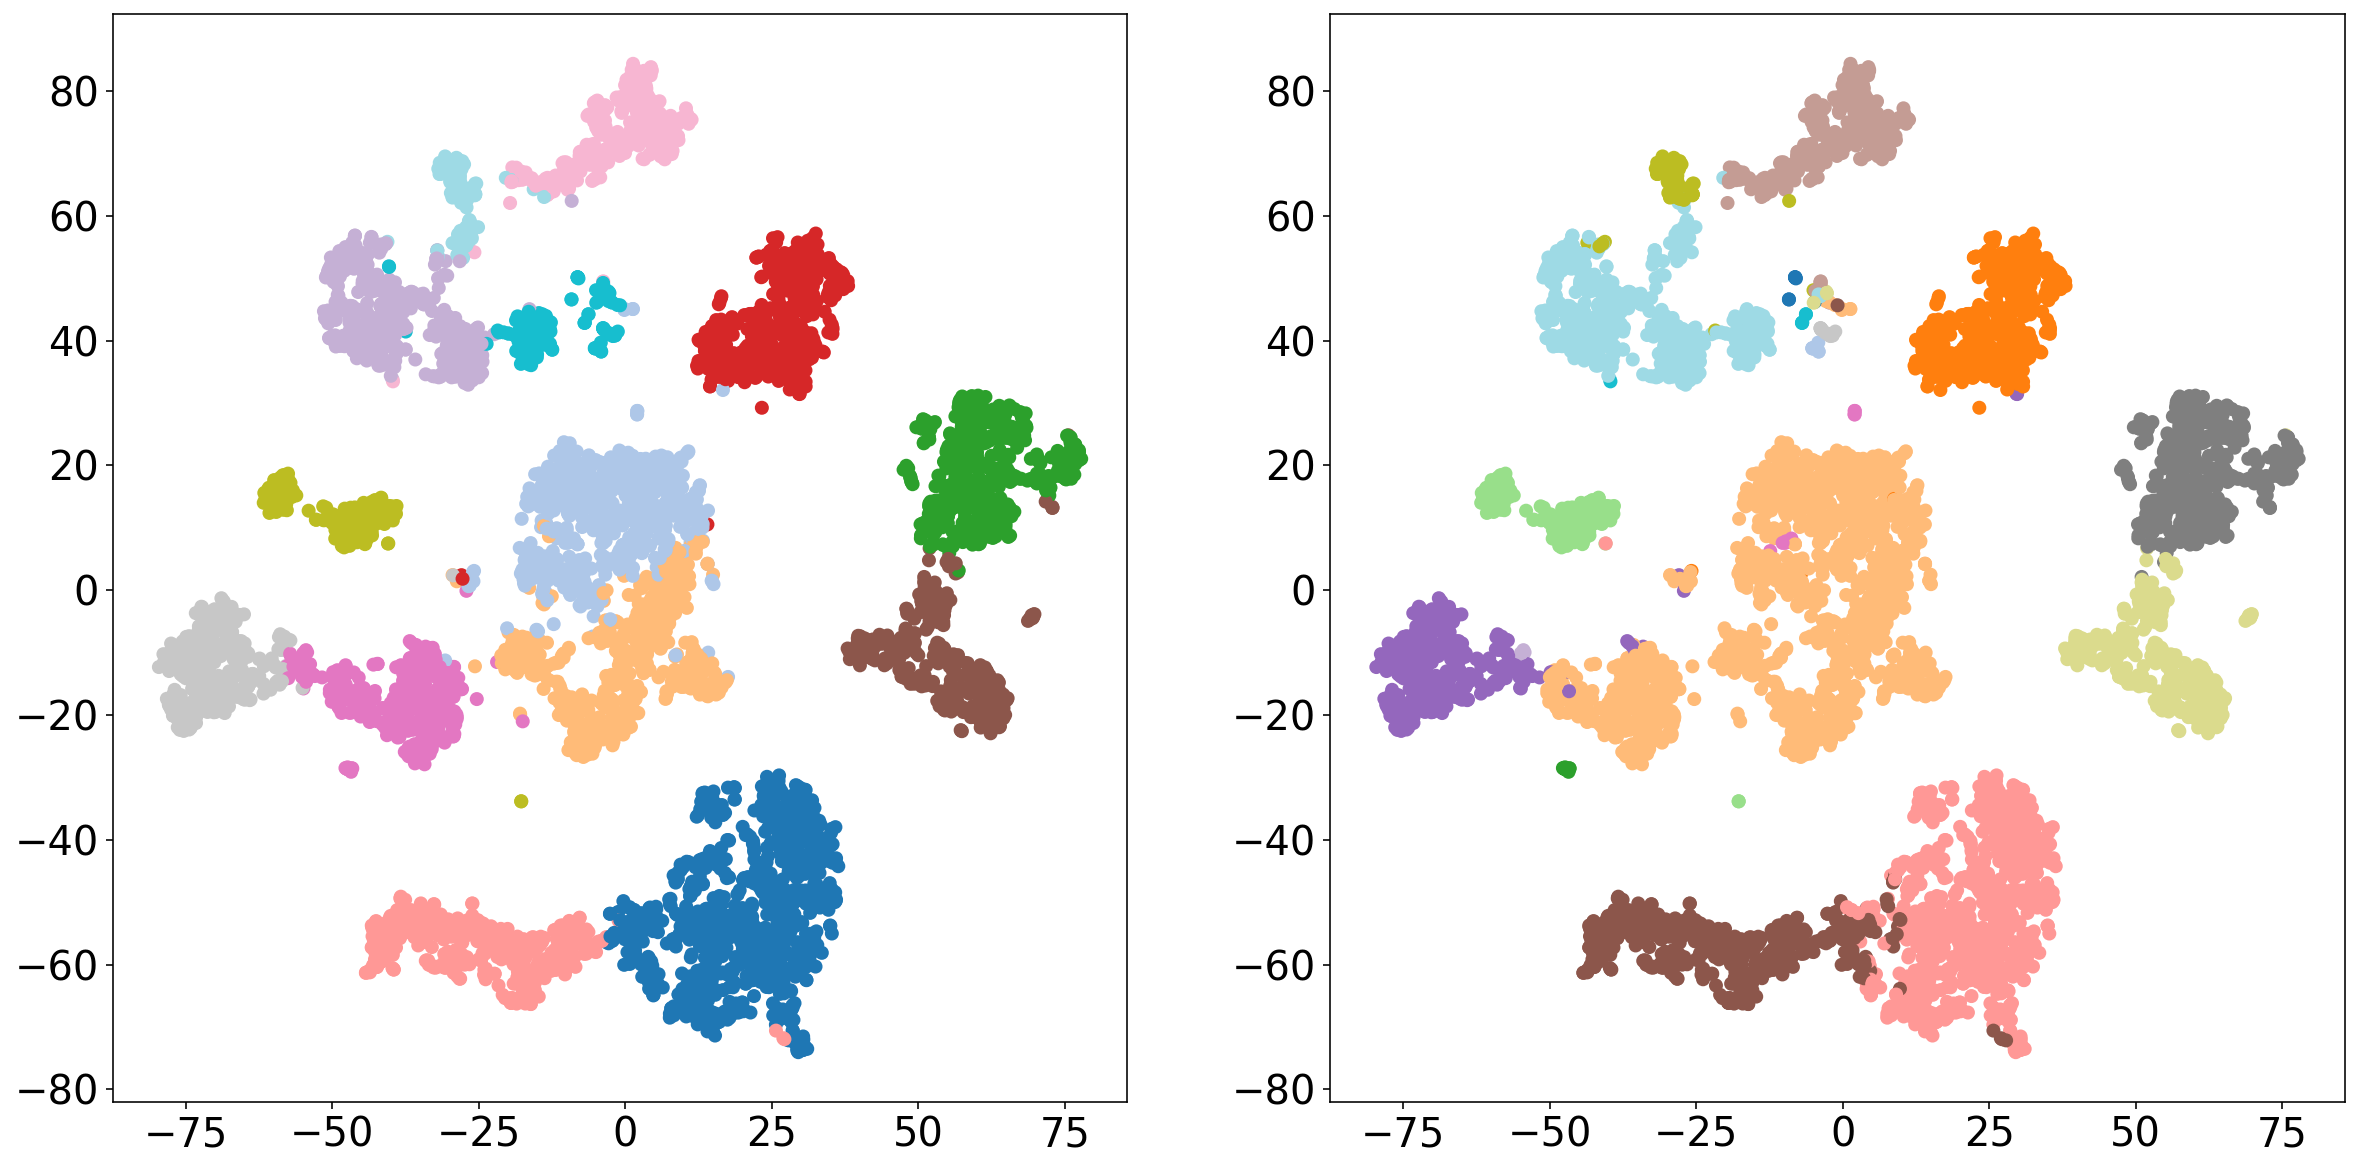

In [99]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)

x = gene.obsm["X_pca_tsne"][:,0]
y = gene.obsm["X_pca_tsne"][:,1]
c = gene.obs["louvain"].astype(int)

ax[0].scatter(x, y, c = c, cmap='tab20')

x = gene.obsm["X_pca_tsne"][:,0]
y = gene.obsm["X_pca_tsne"][:,1]
c = gene.obs["subclass_id"].astype(int)

ax[1].scatter(x, y, c = c, cmap='tab20')

plt.show()

In [100]:
adjusted_rand_score(gene.obs["louvain"].values, gene.obs["subclass_id"].values)

0.7114511029984568

### TSNE on NCA (trained on subclass_labels)

In [101]:
print("Number of NCs: {}".format(num_NCA))

Number of NCs: 10


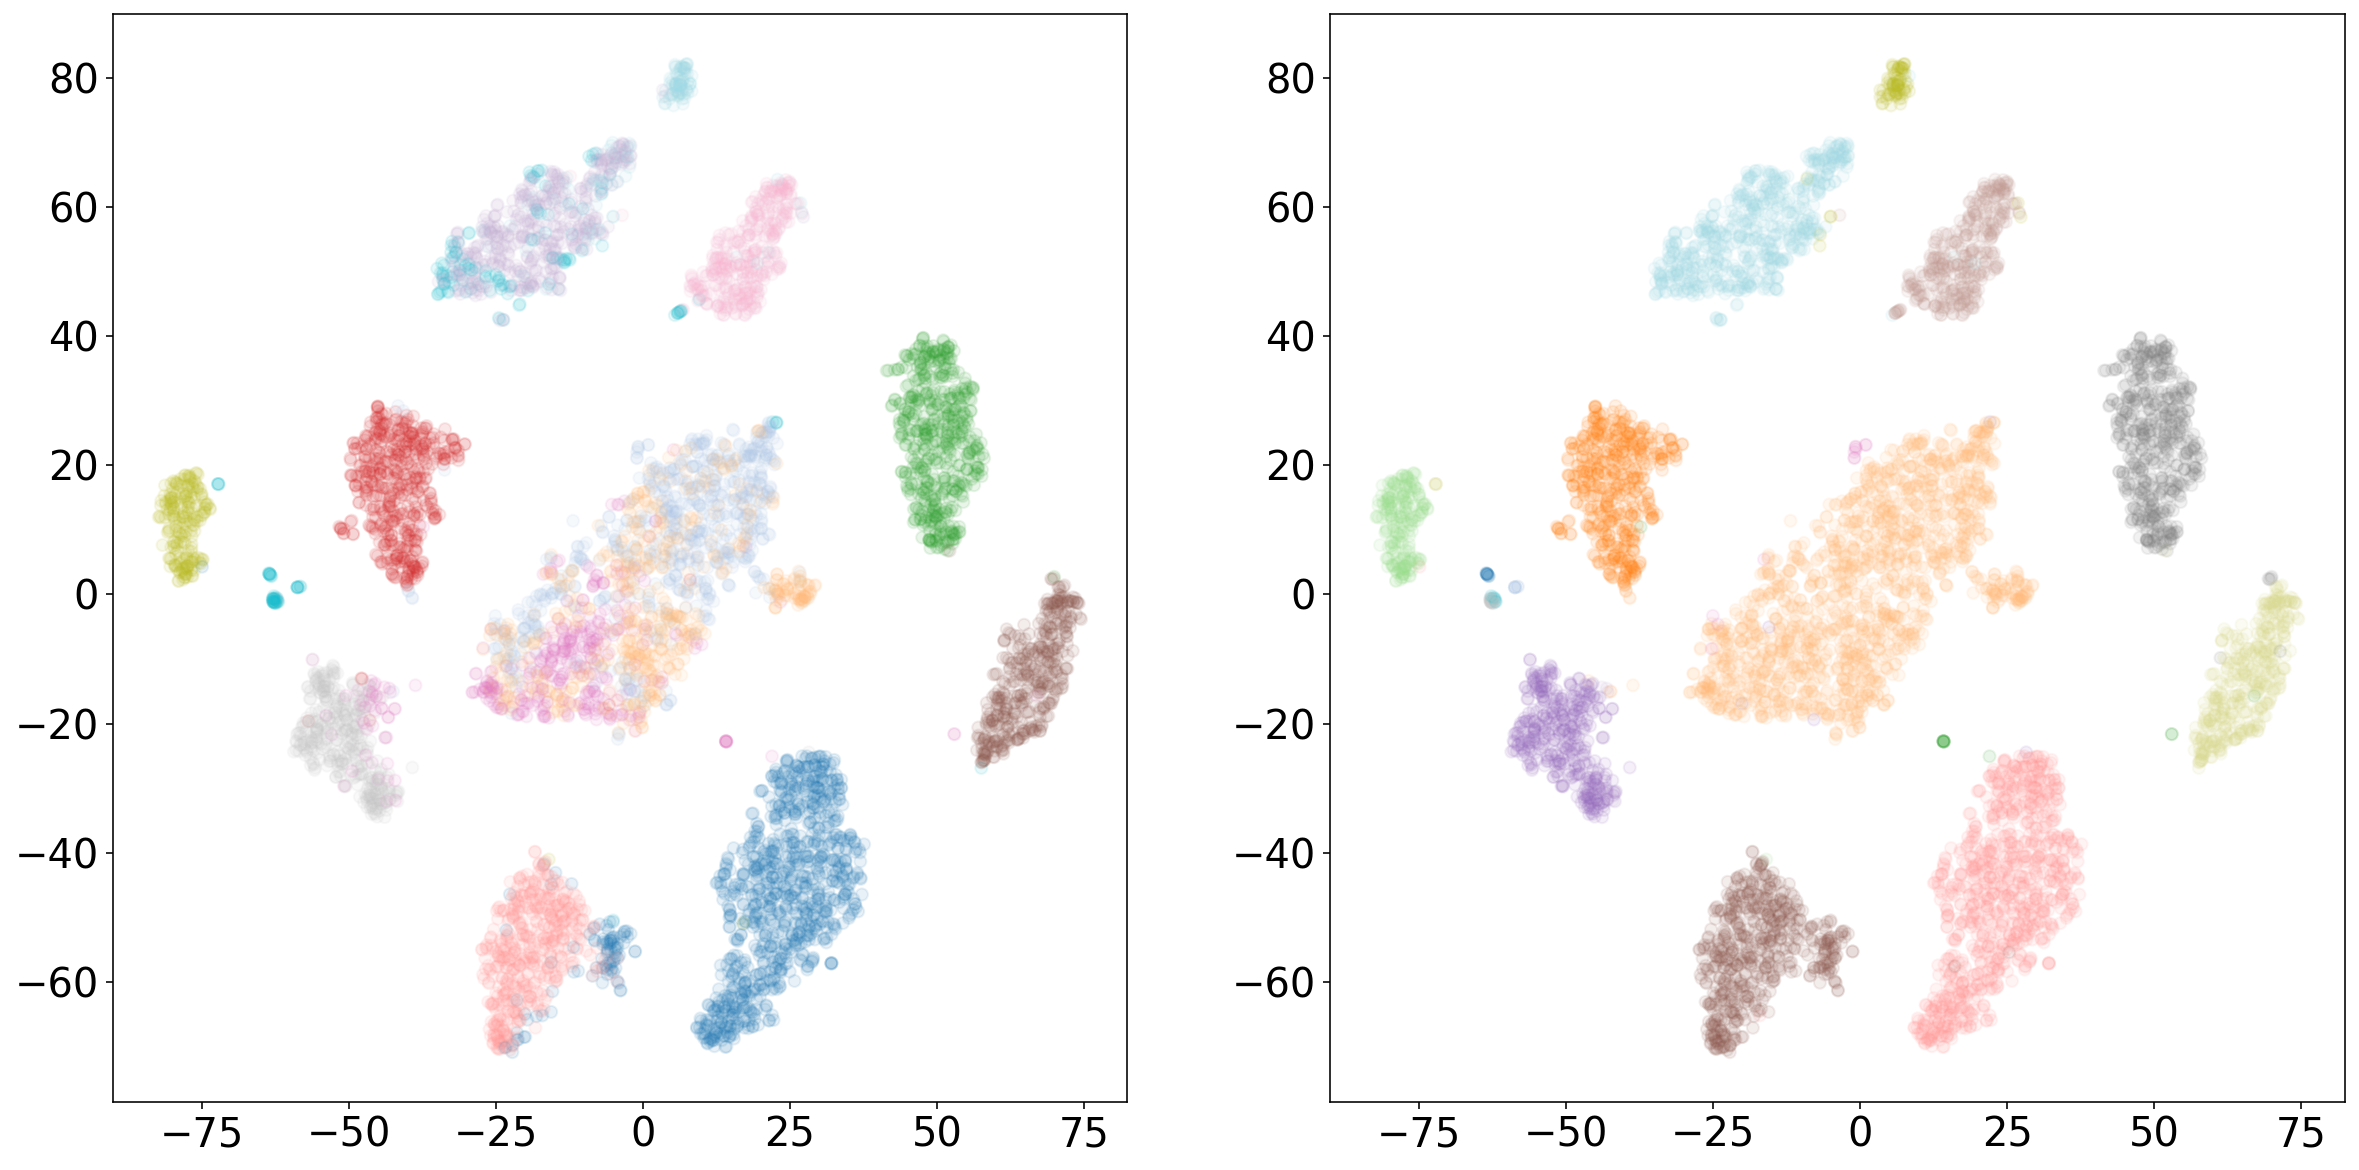

In [102]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["louvain"].astype(int)

ax[0].scatter(x, y, c = c, cmap='tab20', alpha=0.1)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_id"].astype(int)

ax[1].scatter(x, y, c = c, cmap='tab20', alpha=0.1)

plt.show()

# Annotate clusters

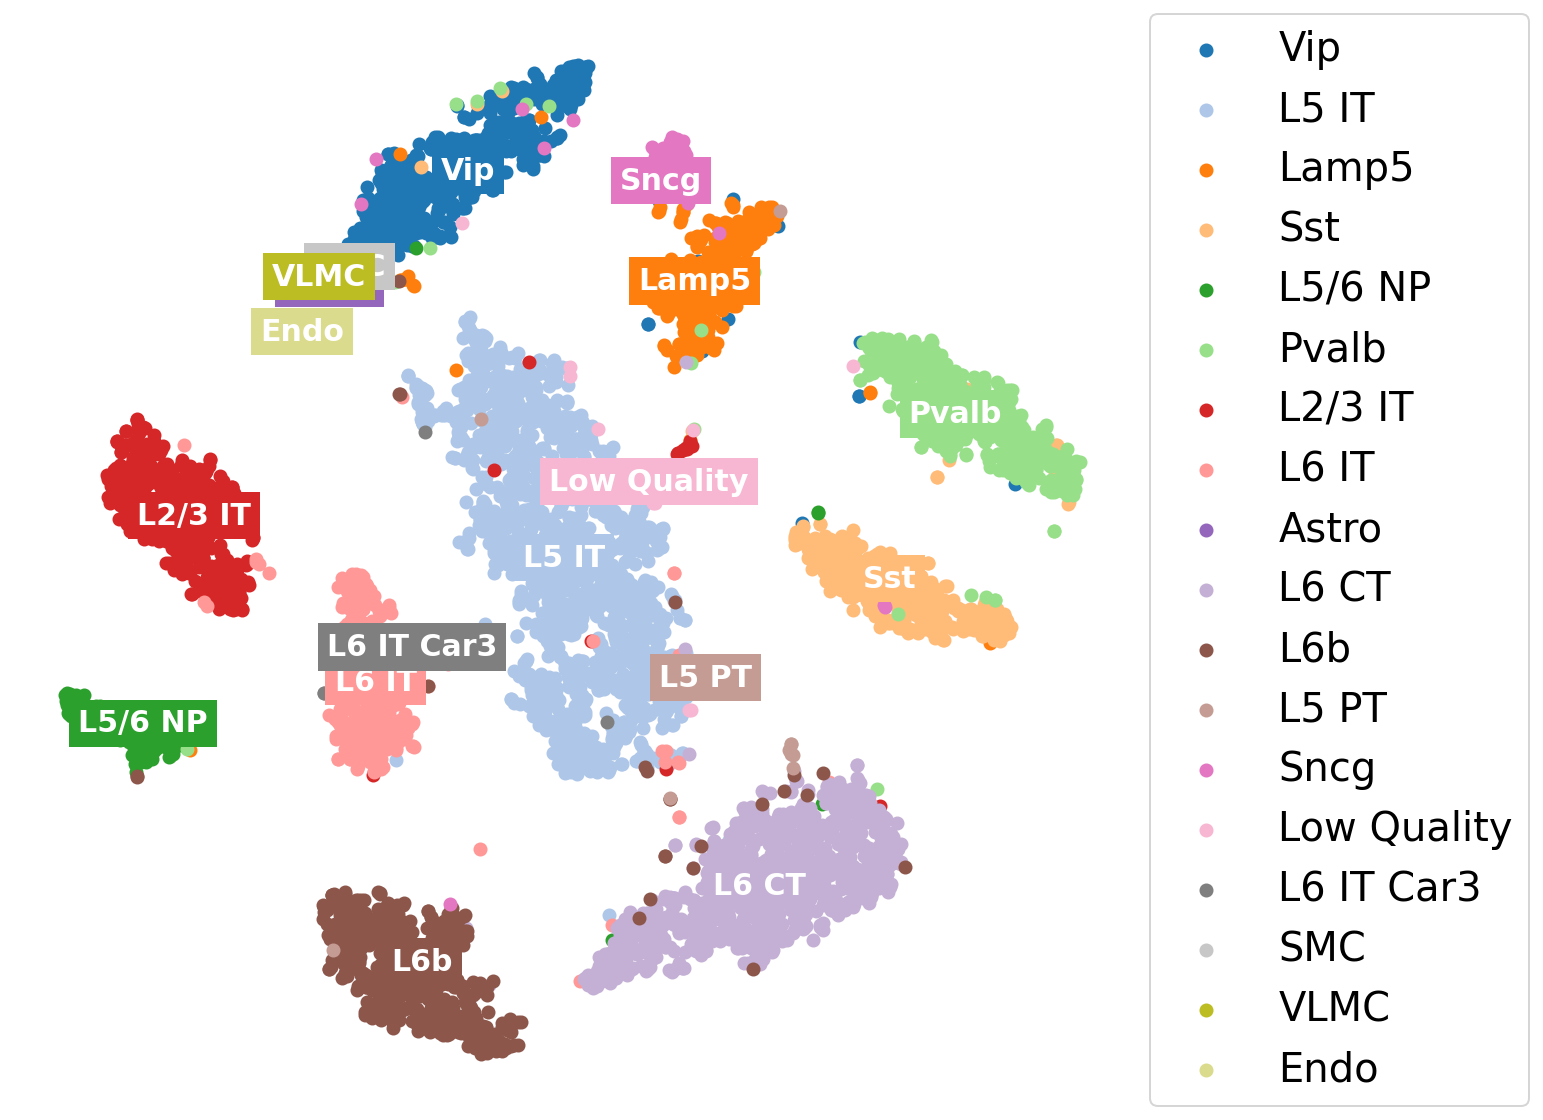

In [107]:
fig, ax = plt.subplots(figsize=(10,10))

c = isoform.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = isoform[isoform.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    if cluster == "Endo": y = y-10
    if cluster == "SMC": y = y+5; x=x+5
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

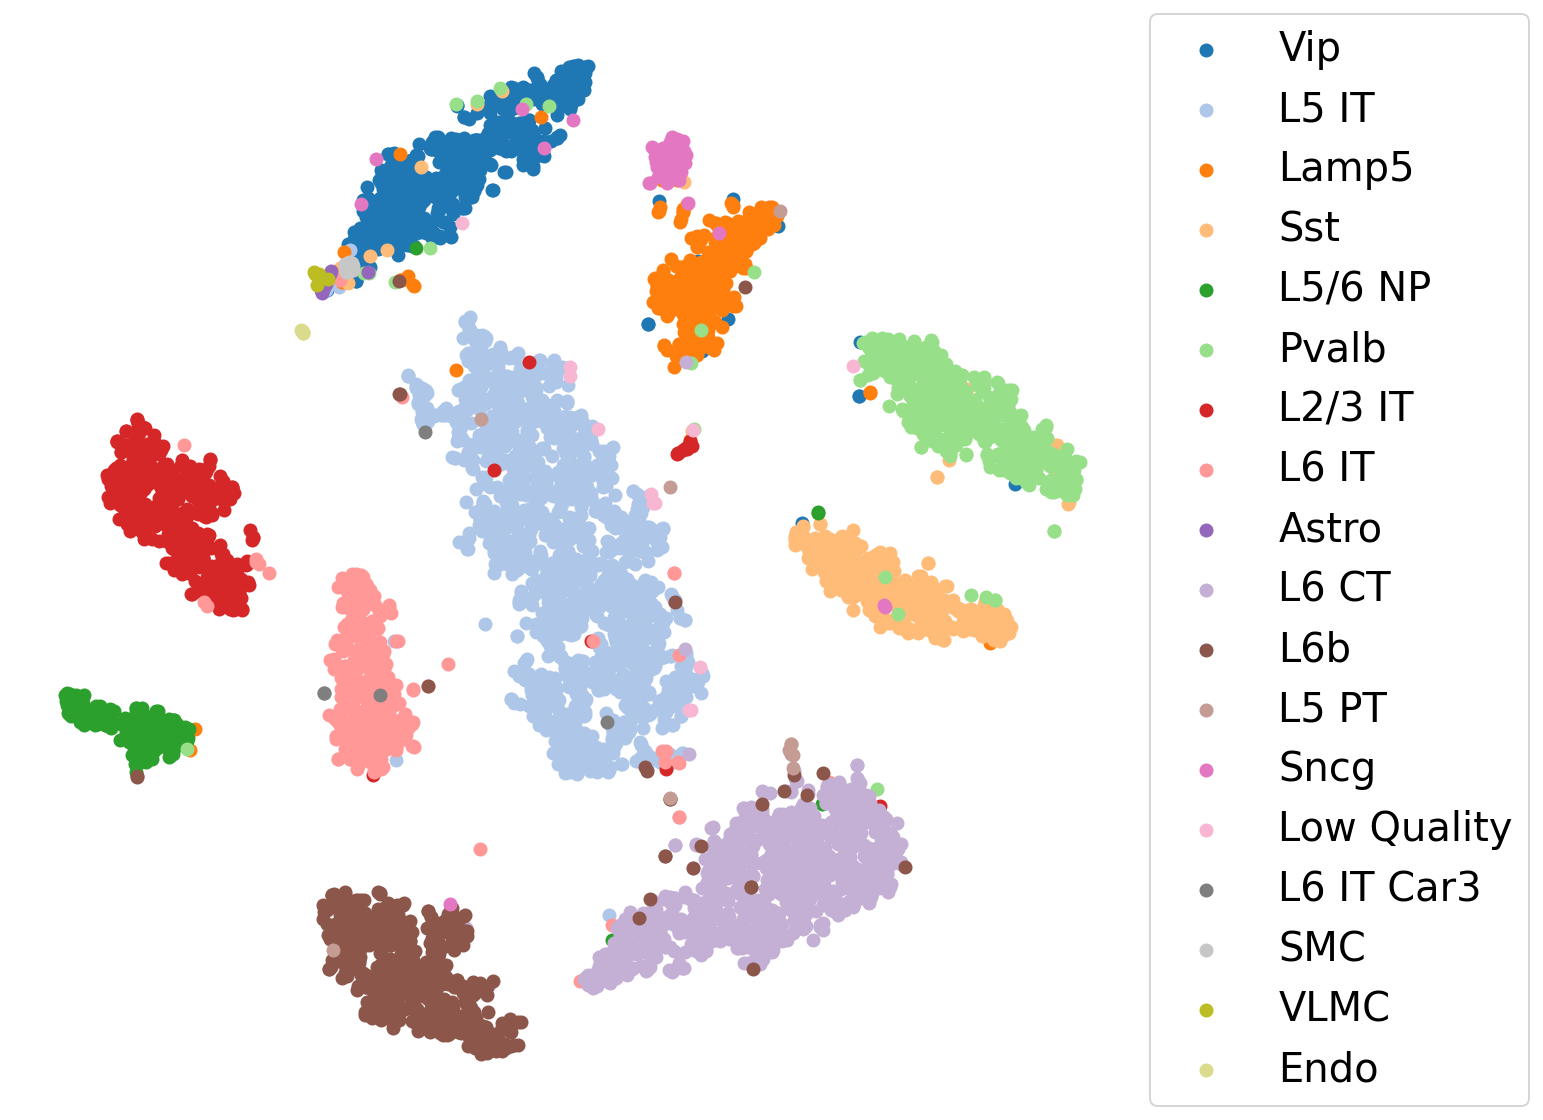

In [108]:
fig, ax = plt.subplots(figsize=(10,10))

c = isoform.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = isoform[isoform.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    if cluster == "Endo": y = y-10
    if cluster == "SMC": y = y+5; x=x+5
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    #ax.annotate(cluster, 
    #         (np.mean(x), np.mean(y)),
    #         horizontalalignment='center',
    #         verticalalignment='center',
    #         size=15, weight='bold',
    #         color="white",
    #           backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

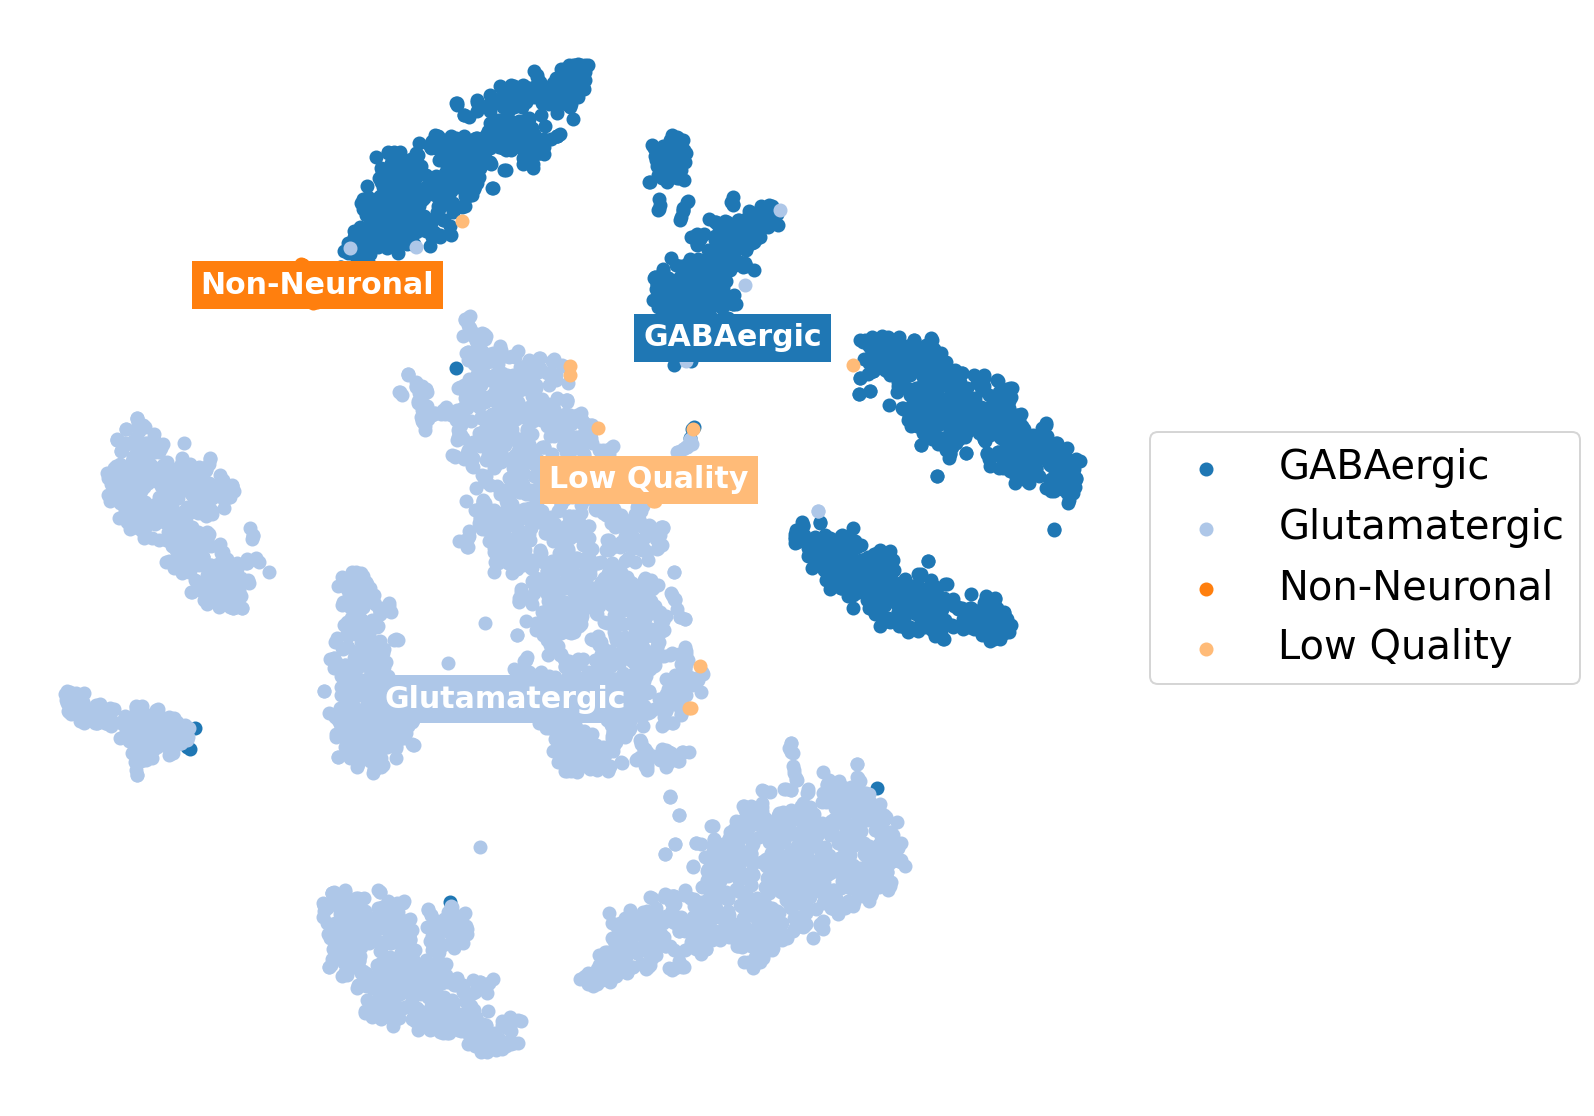

In [109]:
fig, ax = plt.subplots(figsize=(10,10))

c = isoform.obs["class_label"].unique()
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = isoform[isoform.obs.class_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

In [106]:
adata.layers["raw"].sum(axis=1)

matrix([[2231152.],
        [2255496.],
        [2166458.],
        ...,
        [ 482241.],
        [ 442391.],
        [ 578718.]], dtype=float32)